In [16]:
import razor.flow as rf
from razor import api

import logging
import time
import typing as typ
import pandas as pd
import os

from razor.api.core import BlockScope
from razor.api import blocks

In [21]:
blocks.init_bundle(bundle="../test", category="test_cat")

INFO:razor.api.core.block_manager:Block bundle initialized successfully. Please refer ../test/package.yaml to verify/update package.yaml further.


In [24]:
blocks.publish(bundle="../test", scope=BlockScope.PROJECT, overwrite=True)

INFO:razor.api.impl.block_manager_impl:Packaging requested block bundle...
INFO:razor.api.impl.block_manager_impl:Publishing block bundle...
INFO:razor.api.impl.block_manager_impl:Block bundle `test` updated successfully.
INFO:razor.api.impl.block_manager_impl:Make sure to restart the Jupyter kernel and then you can use the blocks as follows:
INFO:razor.api.impl.block_manager_impl:from razor.project.blocks.test import STDIn
INFO:razor.api.impl.block_manager_impl:from razor.project.blocks.test import STDOut


In [2]:
def project_space_path(path):
    ps = api.datasources('Project Space')
    return os.path.join(ps.abspath(), path)

# path = project_space_path("titanic.csv")
# if not os.path.exists(path):
# raise FileNotFoundError(f"File {path} doesn't exist in project space")


In [3]:
# lib1 = razor.api.libraries('pyarrow')

In [4]:
# razor.api.libraries('pyarrow')

In [13]:
@rf.block
class STDIn:    
    filename: str
    out_ds: rf.Output[typ.Any]
#     out_ds: rf.Output[typ.Any] = rf.Output(transport=rf.KafkaTransport)

    def run(self):
        df = pd.read_parquet(project_space_path(self.filename))

        logger.info(df.shape)
        self.out_ds.put(df)


@rf.block
class STDOut:    
    in_ds: typ.Any
    out_filename: str

    def run(self):
        logger.info(self.in_ds.shape)
#         sftp_c = datasources('test_source').client()
        self.in_ds.to_parquet(project_space_path(self.out_filename), index=False)
            

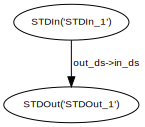

In [14]:
config = {'cores': 1, 'ram': 4096}

size = '10MB'
ip_filename = project_space_path("sdk_testbench/input_data/dummy_"+size+"_df.parquet")
op_filename = project_space_path("sdk_testbench/output_data/tc_01.parquet")

std_in = STDIn(filename=ip_filename)
# std_in.executor = rf.ContainerExecutor(cores=config['cores'], memory=config['ram'])
# std_in.out_ds = rf.Output.set(transport=rf.KafkaTransport)

std_out = STDOut(in_ds=std_in.out_ds, out_filename=op_filename)
# std_out.executor = rf.ContainerExecutor(cores=config['cores'], memory=config['ram'])

pipeline = rf.Pipeline(name='atomic_kafka_transport', targets=[std_out])
pipeline

In [15]:
pipeline.execute()

<Process(Pipeline Manager('atomic_kafka_transport'), stopped)>

In [9]:
import razor
razor.api.pipelines.save(pipeline)

INFO:razor.api.impl.pipeline_manager_impl:Registering pipeline with name: `atomic_kafka_transport`


RuntimeError: STDOut is not a published block. Please use only published block to save a pipeline